In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor')

In [3]:
torch.set_default_tensor_type(torch.DoubleTensor)
# device = torch.device('cuda:0')

In [4]:
# torch.tensor(1).to(device)

In [5]:
# import os
# files = os.listdir('images')

# for i, f in enumerate(files):
#     old_name = f'gray/{f}'
#     new_name = f'gray/gray{i:02}.jpg'
#     !mv $old_name $new_name

In [6]:
def load_image(filename):
    # loads an image in grayscale
    # returns a 2D array (height x width) of intensities between 0 and 1
    img = np.asarray(Image.open(filename).convert('L')) / 255.0
    return torch.tensor(img)

def show_image(arr):
    # Takes in an gray image with intensities from 0 to 1
    arr = np.array(arr)
    arr = (arr * 255).astype(np.uint8)
    scaling = 500 / arr.shape[1]
    
    upscaled = (int(arr.shape[1] * scaling), int(arr.shape[0] * scaling))
    display(Image.fromarray(arr).resize(upscaled))

In [7]:
img = load_image('images/gray00.jpg')

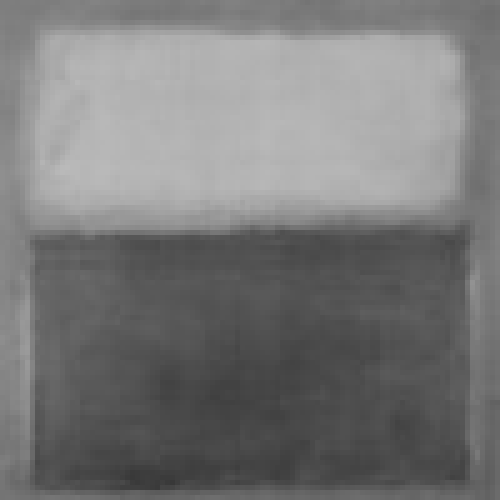

In [8]:
show_image(img)

In [9]:
def boundary_conditions_idx(f):    
    boundary_conditions_y = []
    boundary_conditions_x = []
    
    for y in range(f.shape[0]):
        boundary_conditions_y += [y, y]
        boundary_conditions_x += [0, f.shape[1] - 1]
    
    for x in range(f.shape[1]):
        boundary_conditions_y += [0, f.shape[0] - 1]
        boundary_conditions_x += [x, x]

    return boundary_conditions_y, boundary_conditions_x

In [74]:
class SecondOrderDiffEq:
    """
    A class that evaluates 2nd order diffential equations of 2 variables
    using a discrete finite difference
    """
    def __init__(self, weights=None):        
        # the 9 weights in the 2nd order PDE of 2 variables correspond to (in order):
        # constant, y, x, f, f_y, f_x, f_yy, f_yx, f_xx
        num_weights = 9
        
        if weights is None:
            weights = torch.randn(num_weights, requires_grad=True)
        
        assert len(weights) == num_weights
        self.weights = torch.tensor(weights, requires_grad=True)

    def freeze(self):
        """
        Returns a copy of the DiffEq with weights that don't require grad
        """
        res = SecondOrderDiffEq(self.weights.clone().detach())
        res.weights.requires_grad = False
        return res
    
    def __call__(self, f):
        """
        Evaluate this DiffEq with the given values of the function value `f`
        This uses a discrete finite difference.
        
        `f` should be a 2D torch.tensor
        """
        assert len(f.shape) == 2, 'expected a 2d matrix'
        
        if not isinstance(f, torch.Tensor):
            f = torch.tensor(f)
        f = f.clone()
        
        h = 0.01
        coords, _ = zip(*np.ndenumerate(f.detach()))
        y_coords, x_coords = torch.tensor(coords).T
        y_coords = y_coords.reshape(f.shape).double() * h
        x_coords = x_coords.reshape(f.shape).double() * h
                
        constant = torch.ones(f.shape)
        
        finite_diffs = []
        
        # compute the first order finite differences
        f_y = torch.zeros(f.shape)
        for y in range(1, f.shape[0] - 1):
            f_y[y] = (f[y + 1] - f[y - 1]) / (2 * h);
        
        f_x = torch.zeros(f.shape)
        for x in range(1, f.shape[1] - 1):
            f_x[:,x] = (f[:, x + 1] - f[:, x - 1]) / (2 * h)
        
        
        # compute the second order finite differences
        f_yy = torch.zeros(f.shape)
        for y in range(1, f.shape[0] - 1):
            f_yy[y] = (f[y + 1] - 2*f[y] + f[y - 1]) / (h ** 2)
        
        f_xx = torch.zeros(f.shape)
        for x in range(1, f.shape[1] - 1):
            f_xx[:,x] = (f[:, x + 1] - 2*f[:, x] + f[:, x - 1]) / (h ** 2)
        
        f_yx = torch.zeros(f.shape)
        for y in range(1, f.shape[0] - 1):
            for x in range(1, f.shape[1] - 1):
                # TODO: optimize this to not be a for loop anymore
                a = f[y+1, x+1] - f[y+1, x-1] - f[y-1, x+1] + f[y-1, x-1]        
                f_yx[y, x] = a / (4 * h**2)
                
        # set the boundary conditions to be zero
        boundary_y, boundary_x = boundary_conditions_idx(f)
        values = [constant, y_coords, x_coords, f, f_y, f_x, f_yy, f_yx, f_xx]
        for v in values:
            v[boundary_y, boundary_x] = 0
            
        # evaluate the diffeq
        values = torch.stack(values)
        res = self.weights.unsqueeze(1).unsqueeze(2) * values
        return res.sum(dim=0)

In [53]:
def harcode_boundary(image, internal_f):
    res = image.clone()
    assert res[1:-1, 1:-1].shape == internal_f.shape
    res[1:-1, 1:-1] = internal_f
    return res


def solve_matrix_diff_eq_solve(image, diff_eq):
    image = np.array(image.detach())
    weights = np.array(diff_eq.weights.detach())
    
    w_c, w_y, w_x, w_f, w_f_y, w_f_x, w_f_yy, w_f_yx, w_f_xx = weights
    
    height, width = image.shape
    n = height * width
    
    
    bound_y, bound_x = boundary_conditions_idx(image)
    boundaries = set(zip(bound_y, bound_x))
    
    def idx(r, c):
        return r*width + c
                        
    h = 0.01
    
    # building the differentiation matrix and source term
    diff_mat = np.zeros((n, n))
    source = np.zeros(n)

    for i in range(n):
        row = i // width
        col = i % width
        
        if (row, col) in boundaries:
            diff_mat[i][i] = 1
            source[i] = image[row][col]
            continue
            
        # computing the source term
        source[i] -= w_c
        source[i] -= w_x * col
        source[i] -= w_y * row
        
        # zero order f
        diff_mat[i][i] = w_f
        
        # first order f_x
        diff_mat[i][idx(row, col - 1)] -= w_f_x / (2 * h)
        diff_mat[i][idx(row, col + 1)] += w_f_x / (2 * h)
        
        # first order f_y
        diff_mat[i][idx(row - 1, col)] -= w_f_y / (2 * h)
        diff_mat[i][idx(row + 1, col)] += w_f_y / (2 * h)
        
        # second order f_xx
        diff_mat[i][idx(row, col - 1)] += w_f_xx / (h * h)
        diff_mat[i][idx(row, col)] -= 2 * w_f_xx / (h * h)
        diff_mat[i][idx(row, col + 1)] += w_f_xx / (h * h)
        
        # second order f_yy
        diff_mat[i][idx(row - 1, col)] += w_f_yy / (h * h)
        diff_mat[i][idx(row, col)] -= 2 * w_f_yy / (h * h)
        diff_mat[i][idx(row + 1, col)] += w_f_yy / (h * h)
        
        # second order f_yx
        diff_mat[i][idx(row + 1, col + 1)] += w_f_yx / (4 * h * h)
        diff_mat[i][idx(row - 1, col + 1)] -= w_f_yx / (4 * h * h)
        diff_mat[i][idx(row + 1, col - 1)] -= w_f_yx / (4 * h * h)
        diff_mat[i][idx(row - 1, col - 1)] += w_f_yx / (4 * h * h)
    
    f = np.linalg.solve(diff_mat, source)
    
    
    
    return torch.tensor(f.reshape(image.shape))
        

def solve_diff_eq(image, diff_eq, num_epochs=100, lr=1):
    # set up the "learned" f
    internal_shape = (image.shape[0] - 2, image.shape[1] - 2)
    internal_f = torch.randn(internal_shape, requires_grad=True)

    # optimize `internal_f` to minimize the squared error of the diff_eq
    opt = torch.optim.LBFGS([internal_f], lr=lr)
    for i in range(num_epochs):
        try:
            opt.zero_grad()

            f = harcode_boundary(image, internal_f)
            loss = torch.sum(diff_eq(f) ** 2)
            loss.backward()
            opt.step(lambda: loss)

            if loss.detach() < 1e-8:
                break

            if i % 10 == 0:
                print(f'solve_diff_eq() epoch {i}: {loss.detach():.3g}')
        except KeyboardInterrupt:
            print('Stopping training early')
            break

    print(f'solve_diff_eq() epoch {i} loss: {loss.detach():.3g}')
    return f


In [12]:
def fit_diff_eq(image, num_epochs=1000, l1_penalty=2, lr=0.1):
    image = torch.tensor(image).double()

    diff_eq = SecondOrderDiffEq()

    opt = torch.optim.LBFGS([diff_eq.weights], lr=lr)
    for i in range(num_epochs):
        try:
            opt.zero_grad()

            loss = torch.sum(diff_eq(image) ** 2)
            loss += l1_penalty * diff_eq.weights.abs().sum()

            loss.backward()
            opt.step(lambda: loss)

            print(f'Outer Training Epoch {i} loss: {loss.detach():.3g}')
            print()
        except KeyboardInterrupt:
            print('Stopping training early')
            break
        
    return diff_eq

In [56]:
# generate a fake image from f(x, y) = exp(x) + exp(y)
img = torch.zeros((10, 10))
for x in range(10):
    for y in range(10):
        img[x][y] = np.sin(x/100) + np.cos(y/100)
img.shape

torch.Size([10, 10])

In [87]:
torch.manual_seed(2)
diff_eq = fit_diff_eq(img, num_epochs=1000, l1_penalty=0.5)   

Outer Training Epoch 0 loss: 22

Outer Training Epoch 1 loss: 15.8

Outer Training Epoch 2 loss: 13.3

Outer Training Epoch 3 loss: 11.3

Outer Training Epoch 4 loss: 9.64

Outer Training Epoch 5 loss: 8.31

Outer Training Epoch 6 loss: 7.24

Outer Training Epoch 7 loss: 6.37

Outer Training Epoch 8 loss: 5.67

Outer Training Epoch 9 loss: 5.1

Outer Training Epoch 10 loss: 4.63

Outer Training Epoch 11 loss: 4.26

Outer Training Epoch 12 loss: 3.95

Outer Training Epoch 13 loss: 3.7

Outer Training Epoch 14 loss: 3.5

Outer Training Epoch 15 loss: 3.33

Outer Training Epoch 16 loss: 3.2

Outer Training Epoch 17 loss: 3.09

Outer Training Epoch 18 loss: 3

Outer Training Epoch 19 loss: 2.93

Outer Training Epoch 20 loss: 2.86

Outer Training Epoch 21 loss: 2.81

Outer Training Epoch 22 loss: 2.77

Outer Training Epoch 23 loss: 2.74

Outer Training Epoch 24 loss: 2.71

Outer Training Epoch 25 loss: 2.68

Outer Training Epoch 26 loss: 2.66

Outer Training Epoch 27 loss: 2.64

Outer Train

Outer Training Epoch 227 loss: 1.99

Outer Training Epoch 228 loss: 1.81

Outer Training Epoch 229 loss: 1.94

Outer Training Epoch 230 loss: 1.75

Outer Training Epoch 231 loss: 2.25

Outer Training Epoch 232 loss: 2.04

Outer Training Epoch 233 loss: 2.15

Outer Training Epoch 234 loss: 1.93

Outer Training Epoch 235 loss: 2.49

Outer Training Epoch 236 loss: 2.26

Outer Training Epoch 237 loss: 2.34

Outer Training Epoch 238 loss: 2.11

Outer Training Epoch 239 loss: 2.71

Outer Training Epoch 240 loss: 2.47

Outer Training Epoch 241 loss: 2.53

Outer Training Epoch 242 loss: 2.28

Outer Training Epoch 243 loss: 2.93

Outer Training Epoch 244 loss: 2.66

Outer Training Epoch 245 loss: 2.72

Outer Training Epoch 246 loss: 2.44

Outer Training Epoch 247 loss: 3.13

Outer Training Epoch 248 loss: 2.84

Outer Training Epoch 249 loss: 2.89

Outer Training Epoch 250 loss: 2.6

Outer Training Epoch 251 loss: 3.32

Outer Training Epoch 252 loss: 3.02

Outer Training Epoch 253 loss: 3.06

Ou

In [88]:
diff_eq.weights

tensor([ 0.7930,  1.1223, -0.1932, -1.7019,  0.1722,  0.9570,  0.0338, -0.2268,
        -0.7933], requires_grad=True)

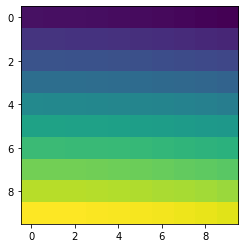

In [89]:
plt.imshow(img)

f error: tensor(1523.5824, grad_fn=<SumBackward0>)


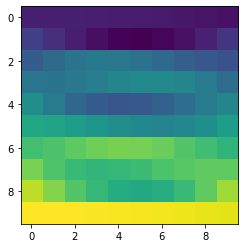

In [93]:
f = solve_matrix_diff_eq_solve(img, diff_eq)
print('f error:', torch.sum(diff_eq(f) ** 2))
plt.imshow(f.detach().numpy());

In [45]:
img = torch.zeros((20, 20))
for x in range(20):
    for y in range(20):
        img[x][y] = np.sin(x/100) + np.cos(y/100)
img.shape

torch.Size([20, 20])

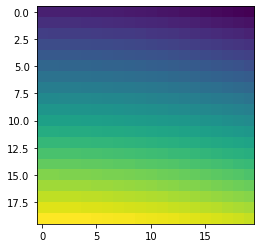

In [46]:
plt.imshow(img)

In [ ]:
f = solve_diff_eq(img, diff_eq, 5000, lr=0.5)

In [ ]:
plt.imshow(f.detach().numpy())